### <center>*COMP8240 - fastText Implementation on Ask Ubuntu Dataset*</center>

**Stack Exchange - Data Scraping for Questions and Tags**

We want to scrape the distributions of numbers of Questions & Tags for the webpage [Stack Exchange - Ask Ubuntu](https://askubuntu.com/) to see if we find anything interesting. To do this, we’ll first scrape data related to Questions and Tags from Stack Exchange webpage for all the respective pages.

**Working out which pages to scrape**

  Once we've defined our goal, we then need to identify an efficient set of pages to scrape. In order to scrape data from the respective web pages, we use `BeautifulSoup` and `request` library. A request is what happens when we access a web page. We 'request' the content of a page from the server.

In [1]:
# Importing all the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import requests
from requests import get
import warnings
warnings.filterwarnings("ignore")                    # To suppress the warnings
from requests import get
from bs4 import BeautifulSoup                        # To scrap and parse data as HTML
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.util import *
from nltk.corpus import stopwords                    # To Remove stopwords from the list for plotting purpose
import re                                            # To handle and substitue special and bad characters in text
import seaborn as sns
from collections import defaultdict

In [2]:
# Hitting the URL for the webpages where the questions are present and getting the response from the webpage.

url = 'https://askubuntu.com/questions'
time.sleep(5)
# Getting the response from the source URL.
response = get(url)
print(response.text[:500])

<!DOCTYPE html>


    <html class="html__responsive">

    <head>

        <title>Newest Questions - Ask Ubuntu</title>
        <link rel="shortcut icon" href="https://cdn.sstatic.net/Sites/askubuntu/Img/favicon.ico?v=928dfb7c1990">
        <link rel="apple-touch-icon" href="https://cdn.sstatic.net/Sites/askubuntu/Img/apple-touch-icon.png?v=e16e1315edd6">
        <link rel="image_src" href="https://cdn.sstatic.net/Sites/askubuntu/Img/apple-touch-icon.png?v=e16e1315edd6"> 
        <lin


As we can see from the first line of response.text, the server sent us an HTML document. This document describes the overall structure of that web page, along with its specific content (which is what makes that particular page unique).

In [3]:
# Parsing respose.txt by creating a BeautifulSoup object and assigning it to htlm_soup.

time.sleep(5)
html_soup = BeautifulSoup(response.text, 'html.parser')


In [4]:
# Printing the total questions summary for each page (pagination set to 50 for viewing purpose)
# The div tag has a class named question-summary that displays to us the entire information for a question posted.

Questions_EachPage = html_soup.find_all('div', class_ = 'question-summary')
print(type(Questions_EachPage))
print(len(Questions_EachPage))

<class 'bs4.element.ResultSet'>
50


As we can see the question summary class count comes out to be 50, which is what we had expected depending on the pagination that we have set.

However, we are only interested to scrape the Questions from this summary and not other things like time, comments, votes, answers,views etc. So, we will only deal with the tag `<h3>` and `<a>`.

**Extracting data for a single question:**


In [5]:
# Printing out the HTLM content of our first question.

first_question = Questions_EachPage[0]
print(first_question)

<div class="question-summary" id="question-summary-1289458">
<div class="statscontainer">
<div class="stats">
<div class="vote">
<div class="votes">
<span class="vote-count-post"><strong>0</strong></span>
<div class="viewcount">votes</div>
</div>
</div>
<div class="status unanswered">
<strong>0</strong>answers
            </div>
</div>
<div class="views" title="10 views">
    10 views
</div>
</div>
<div class="summary">
<h3><a class="question-hyperlink" href="/questions/1289458/key-map-combined-keys-to-combined-keys">key map: combined keys to combined keys</a></h3>
<div class="excerpt">
            In short, I want to map Ctrl+H/L to Ctrl+Left/Right without autokey, and xbindkeys+xdotool/xvkbd does not work. Details are as follows:
I am now using autokey to achieve the mapping, it works very ...
        </div>
<div class="tags t-shortcut-keys t-keyboard-layout t-xdotool">
<a class="post-tag" href="/questions/tagged/shortcut-keys" rel="tag" title="show questions tagged 'shortcut-keys'">

As we can see, the HTML content of one container is very long. To find out the HTML line specific to each data point, we’ll use DevTools once again.

In [6]:
# Hitting the webpage to validate if there are any timeouts or connection reset warnings using try except()

from urllib.request import urlopen 
from socket import timeout

url = "https://askubuntu.com/questions?tab=newest&pagesize=50"
try: 
    string = urlopen(url, timeout=5).read()
except ConnectionResetError:
    print("==> ConnectionResetError")
    pass
except timeout: 
    print("==> Timeout")
    pass

In [7]:
pages_list=[]                         # Empty list that will be appended with the page count

pages_list.append("https://askubuntu.com/questions?tab=newest&pagesize=50")

for page in list(range(2, 601)):     # Looping over first 600 webpages

  pages_list.append('https://askubuntu.com/questions?tab=newest&page='+str(page))
  
print(len(pages_list))

600


**Interpretation:** *We created an empty list of pages and then we are looping over the required number of webpages (600 in this case) and later appending the list with the total length of the webpages.*

In [8]:
# Scraping Questions from 600 webpages.

questions_list=[]                     # Creating an empty list of questions that will be appended with the question counts.

# time.sleep(5)
for x in pages_list:                  # Looping over all the pages in the page list
  page = requests.get(x)
  soup = BeautifulSoup(page.text, 'html.parser')

  question_name = soup.find_all('h3')   # Finding the h3 tag that has details of the question
  for question in question_name:
        if question.find('a'):
            questions_list.append(question.find('a').text)

**Interpretation:** *Here, we are identifying the respective HTML tags that contain the questions that we need to scrape.(`<h3> and <a>`) and looping over the page length that we fetched in initial code (600 webpages) to scrape 30K Questions(page size =50)*

In [81]:
# Printing the length of the questions scraped and the top 10 questions.

print(len(questions_list))

# Displaying the top 10 questions.
print(questions_list[:11])

31200
['current community', 'more stack exchange communities', 'I am currently trying to install CMake to Ubuntu-20.04 via WSL but I get dependency error', 'key map: combined keys to combined keys', 'Ubuntu stuck at spinning logo at boot time', 'Fresh ubuntu 20.04 install but unclaimed nvidia graphic card?', 'Unable to install ubuntu Checksum “No such file or directory”', 'How do you make a button that performs a specific command?', 'Ubuntu changes filepath name of hard drive', 'Will Ubuntu server 20.04.1 support USB boot on Raspberry Pi 4', 'Bad Ubuntu system update, gnome gone']


**Interpretation:** *As we can see that we have obtained the questions length as 31200. The length of questions should have been 30K instead of 31200 because the page size is 50 and we are scraping data for first 600 webpages, but there were two questions that were scraped for each page by default which are (`'current community', 'more stack exchange communities'`), so we have 1200 extra questions and we are handling  and filtering out these 1200 questions using the below code.*

In [82]:
# Creating a list of the two questions to be removed.

to_remove = ["current community","more stack exchange communities"]

In [83]:
# Creating a DataFrame of the Questions scraped.

ask_ubuntu_df = pd.DataFrame(questions_list, columns =['Questions'])
ask_ubuntu_df.head()

,Questions
0,current community
1,more stack exchange communities
2,I am currently trying to install CMake to Ubuntu-20.04 via WSL but I get dependency error
3,key map: combined keys to combined keys
4,Ubuntu stuck at spinning logo at boot time


In [84]:
ask_ubuntu_df = ask_ubuntu_df[~ask_ubuntu_df['Questions'].isin(to_remove)]
# print(len(questions_df))
ask_ubuntu_df.head()

,Questions
2,I am currently trying to install CMake to Ubuntu-20.04 via WSL but I get dependency error
3,key map: combined keys to combined keys
4,Ubuntu stuck at spinning logo at boot time
5,Fresh ubuntu 20.04 install but unclaimed nvidia graphic card?
6,Unable to install ubuntu Checksum “No such file or directory”


**Interpretations:** *We are removing the two default questions as mentioned above and storing the result of the updated questions in a dataframe and printing the top 5 records, so as to check that we are not getting the 2 removed questions now.*

In [85]:
# Printing the length of the questions.
print(len(ask_ubuntu_df))

30000


In [13]:
# Defining a function that will be used in the below code cell to extract tags based on class name and HTML tag of interest

def ListToString(string):
  # initialize an empty string 
  string1 = ""
    
  # traverse in the string   
  for element in string:  
      string1 = string1 + element   
     
  return string1

In [ ]:
# Appending the tag list with after looping over all the web pages list and scrapping tags 
# belonging to respective HTML class and replacing the default symbol with | to separate tags from each other.

tag=[]                          # Empty list of tag that will be appended with cleaned tags at the end.

for x in pages_list:            # Looping over all the webpages and storing the page response as HTML after parsing.
  page = requests.get(x)        
  soup = BeautifulSoup(page.text, 'html.parser')

  tags=[]                       # Empty list that will be appended with the respective scraped tag after identifying 
                                # the respective classes for scraping tags.
  for div in soup.find_all('div', {"class": re.compile("^tags")}):      
    tags.append(div.get('class')[1:])



  clean_tags=[]

  for i in tags:                 # Empty list appended after cleaning tags by replacing the default t-
    clean_tags.append(ListToString(i).replace('t-','|'))



  for j in clean_tags:           # Finally, the cleaned tags are appended to the initial tag list that we defined.
    tag.append(j[1:])

In [86]:
print("The length of the scraped questions is:", len(ask_ubuntu_df))
print("The length of the scraped tags is:", len(tag))
print(tag[:11])

The length of the scraped questions is: 30000
The length of the scraped tags is: 30000
['apt|windows-subsystem-for-linux', 'shortcu|keys|keyboard-layout|xdotool', 'boot|nvidia', 'drivers|nvidia|20û04|graphics', 'checksums', '20û04|button', 'dual-boot|mount|hard-drive', 'boot|usb|20û04|raspberrypi', 'upgrade|20û04', 'usb|permissions|firefox', 'kernel|dell|xps']


**Interpretation:** *As we can see that earlier the Questions length and tags length was not matching (Questions scraped for 600 webpages were 31200 and tags were 30000. So after removing those two default questions, we can now see from the above output that, the length of both questions and tags is now coming out to be same.*

In [87]:
# Creating a dataframe for questions and tags

ask_ubuntu_df['Tags'] = tag
ask_ubuntu_df.head()

,Questions,Tags
2,I am currently trying to install CMake to Ubuntu-20.04 via WSL but I get dependency error,apt|windows-subsystem-for-linux
3,key map: combined keys to combined keys,shortcu|keys|keyboard-layout|xdotool
4,Ubuntu stuck at spinning logo at boot time,boot|nvidia
5,Fresh ubuntu 20.04 install but unclaimed nvidia graphic card?,drivers|nvidia|20û04|graphics
6,Unable to install ubuntu Checksum “No such file or directory”,checksums


**Interpretation:** *Below we are just appending the Tags to the initial dataframe that just contained the scraped Questions.*

In [59]:
# Creating a func() called build_ngrams to analyse data in the form of unigrams, bigrams, ngrams etc.

def build_ngrams(clean_text, ngram):
    clean_text = clean_text.lower()
    clean_text = remove_space.sub(' ', clean_text)
    clean_text = bad_symbols.sub(' ', clean_text)
    clean_text = ' '.join(word for word in clean_text.split() if word not in STOPWORDS) 
    tokenize = nltk.word_tokenize(clean_text)
    return list(ngrams(tokenize, ngram))

In [60]:
# Handling spaces in text and bad symbols and eliminating those using regex.

remove_space = re.compile('[/(){}\[\]\|@,;]')
bad_symbols = re.compile('[^a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [61]:
# Looping over questions list and building unigrams from the list.

onegram_tags_freq = defaultdict(int)
for sentence in ask_ubuntu_df['Questions']:
    for word in build_ngrams(sentence, 1):
        onegram_tags_freq[word] = onegram_tags_freq[word] + 1

In [62]:
def plot_horizontal_bar(data, title):
    plt.figure(figsize=(20, 15))
    freq = pd.DataFrame(sorted(data.items(), key=lambda x: x[1]), columns=['Words','Count'])
    sns.barplot(x='Count', y='Words', data=freq.sort_values(by="Count", ascending=True).tail(30))
    plt.title(title)
    plt.tight_layout()
    plt.show()

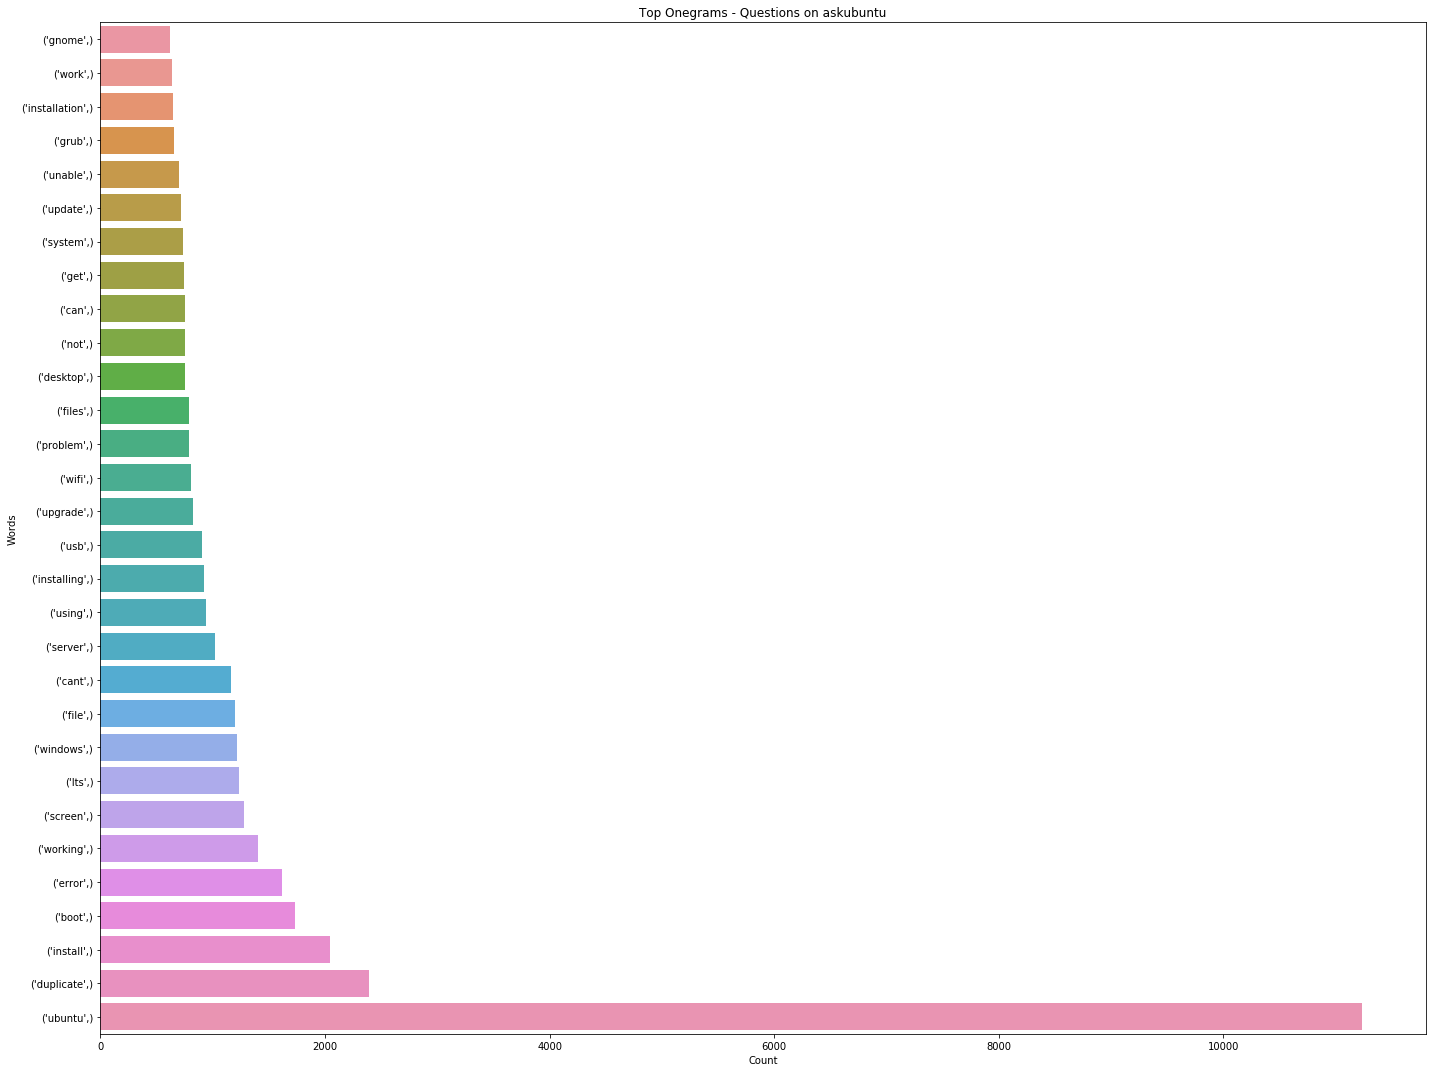

In [63]:
plot_horizontal_bar(onegram_tags_freq, 'Top Onegrams - Questions on askubuntu')

In [64]:
bigrams_tags_freq = defaultdict(int)
for sentence in ask_ubuntu_df['Questions']:
    for word in build_ngrams(sentence, 2):
        bigrams_tags_freq[word] = bigrams_tags_freq[word] + 1

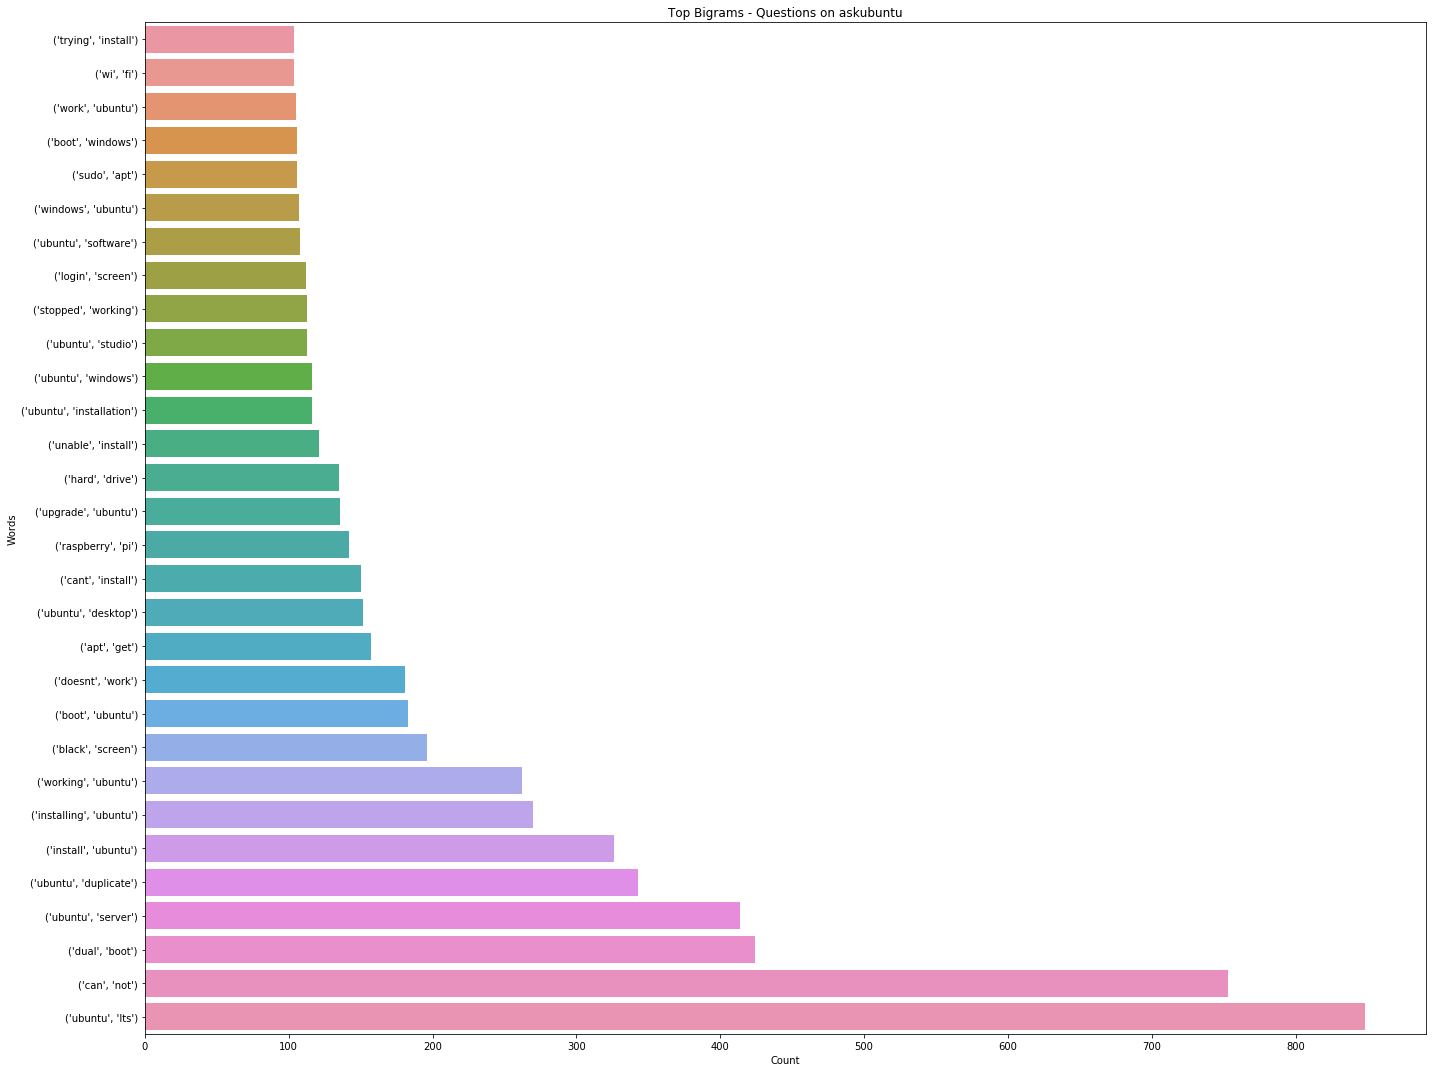

In [65]:
plot_horizontal_bar(bigrams_tags_freq, 'Top Bigrams - Questions on askubuntu')

In [68]:
trigrams_tags_freq = defaultdict(int)
for sentence in ask_ubuntu_df['Questions']:
    for word in build_ngrams(sentence, 3):
        trigrams_tags_freq[word] = trigrams_tags_freq[word] + 1

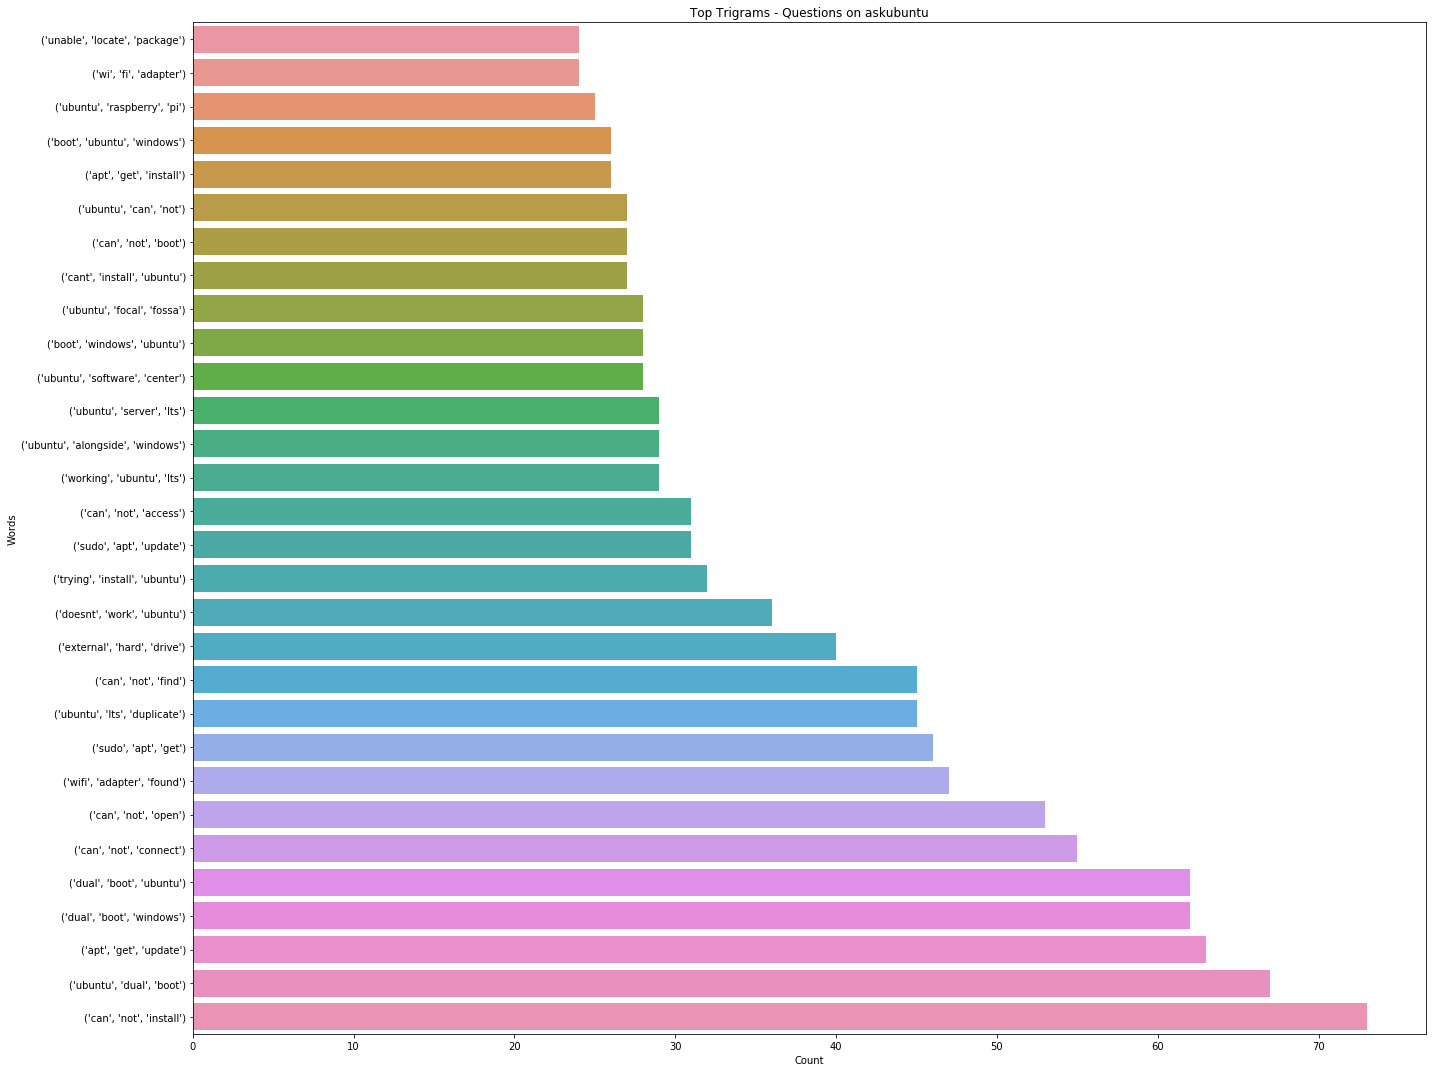

In [69]:
plot_horizontal_bar(trigrams_tags_freq, 'Top Trigrams - Questions on askubuntu')

In [24]:
# Removing special characters, hyperlinks/URL's from the Questions and Tags.

ask_ubuntu_df['Questions'] = ask_ubuntu_df['Questions'].str.replace(';','').str.replace(':','').str.replace('/','or').str.replace('(','').str.replace(')','').str.replace('()','').str.replace('[','').str.replace(']','').str.replace('"','').str.replace("'",'').str.replace('.','')

# Handling the special character for the version of tags.
ask_ubuntu_df['Tags'] = ask_ubuntu_df['Tags'].str.replace('û','.')

**Interpretation:** *In the above code, we are handling and replacing all the special characters from both Questions and tags column.*

In [25]:
# Joining all the tags and storing those in a variable for plotting in a wordcloud
ask_ubuntu_tags = ' '.join(ask_ubuntu_df['Tags'].str.lower())

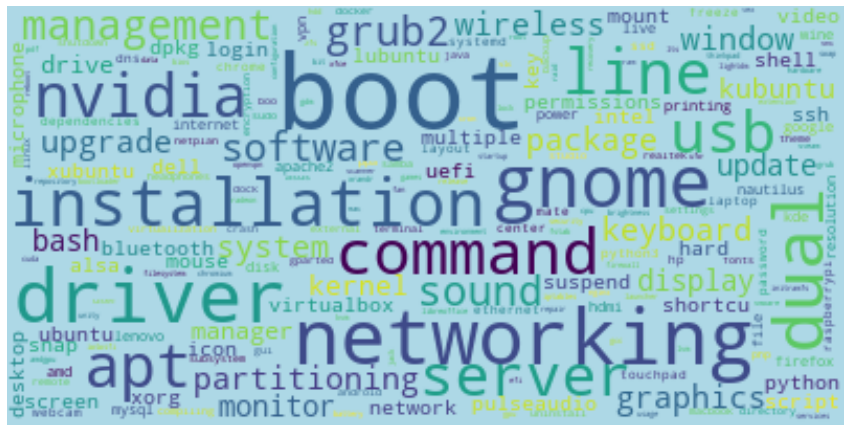

In [26]:
wordcloud = WordCloud(max_font_size=50, collocations=False, background_color='lightblue').generate(ask_ubuntu_tags)
plt.figure(figsize=(15,12))
# plot wordcloud in matplotlib
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Interpretation:** *From the word cloud , we can interpret that some words which have most frequently occured in the tags are `boot, networking, driver, installation etc`*.

In [88]:
ask_ubuntu_df["Tags"] = [item.replace("|", " __label__") for item in ask_ubuntu_df["Tags"]]
ask_ubuntu_df['Tags'] ='__label__' + ask_ubuntu_df['Tags'].astype(str)
ask_ubuntu_df.head()

,Questions,Tags
2,I am currently trying to install CMake to Ubuntu-20.04 via WSL but I get dependency error,__label__apt __label__windows-subsystem-for-linux
3,key map: combined keys to combined keys,__label__shortcu __label__keys __label__keyboard-layout __label__xdotool
4,Ubuntu stuck at spinning logo at boot time,__label__boot __label__nvidia
5,Fresh ubuntu 20.04 install but unclaimed nvidia graphic card?,__label__drivers __label__nvidia __label__20û04 __label__graphics
6,Unable to install ubuntu Checksum “No such file or directory”,__label__checksums


**Interpretation:** *This is the part where we are actually modifying the tags to apply labels of the form (`__label__`) before each tag , as this is the default format that fastText accepts for a classifier to train and run upon.*

In [ ]:
# Re-indexing the columns to display tags before questions in the dataframe.

pd.set_option('display.max_colwidth', 100)
columns_titles = ["Tags","Questions"]
ask_ubuntu_df=ask_ubuntu_df.reindex(columns=columns_titles) #reindexing the two columns of dataframe
ask_ubuntu_df.head()

In [29]:
# Setting the current working directory

relative_path = "/Users/Agam/Project Files/"
os.chdir(relative_path)

In [30]:
# Cloning and Installing fastText
!git clone https://github.com/facebookresearch/fastText.git
%cd fastText
!make
!cp fasttext ../
%cd ..

Cloning into 'fastText'...
remote: Enumerating objects: 3854, done.
remote: Total 3854 (delta 0), reused 0 (delta 0), pack-reused 3854
Receiving objects: 100% (3854/3854), 8.22 MiB | 4.13 MiB/s, done.
Resolving deltas: 100% (2417/2417), done.
/Users/Agam/Project Files/fastText
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/args.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/autotune.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/matrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/dictionary.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/loss.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/productquantizer.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/densematrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/quantmatrix.cc
c++ -pthread -std=c++11 -march=nativ

In [31]:
# Changing the respective path to the fastText directory after cloning fastText.

relative_path = "/Users/Agam/Project Files/fastText"
os.chdir(relative_path)

In [32]:
# Save the DataFrame as a .txt file which is required for feeding to fastText

np.savetxt('/Users/Agam/Project Files/fastText/ask_ubuntu.txt', ask_ubuntu_df.values, fmt='%s', delimiter='\t')

**Interpretation:** *We are saving the dataframe values of questions and tags in the form of a .txt file which is accepted by fastText for training a classifier.*

In [33]:
!head "/Users/Agam/Project Files/fastText/ask_ubuntu.txt"

__label__apt __label__windows-subsystem-for-linux	I am currently trying to install CMake to Ubuntu-2004 via WSL but I get dependency error
__label__shortcu __label__keys __label__keyboard-layout __label__xdotool	key map combined keys to combined keys
__label__boot __label__nvidia	Ubuntu stuck at spinning logo at boot time
__label__drivers __label__nvidia __label__20.04 __label__graphics	Fresh ubuntu 2004 install but unclaimed nvidia graphic card?
__label__checksums	Unable to install ubuntu Checksum “No such file or directory”
__label__20.04 __label__button	How do you make a button that performs a specific command?
__label__dual-boot __label__mount __label__hard-drive	Ubuntu changes filepath name of hard drive
__label__boot __label__usb __label__20.04 __label__raspberrypi	Will Ubuntu server 20041 support USB boot on Raspberry Pi 4
__label__upgrade __label__20.04	Bad Ubuntu system update, gnome gone
__label__usb __label__permissions __label__firefox	Permission denied when trying to run F

In [34]:
# Splitting the data into training, validation and testing.

train_data= round(len(ask_ubuntu_df)*0.70)
validation_data = round(len(ask_ubuntu_df)*0.15)
testing_data = round(len(ask_ubuntu_df)*0.15) 

print("Number of records for training dataset are:", train_data)
print("Number of records for validation dataset are:", validation_data)
print("Number of records for testing dataset are:", testing_data)

Number of records for training dataset are: 21000
Number of records for validation dataset are: 4500
Number of records for testing dataset are: 4500


**Interpretation:** *Here, we are splitting the dataset into three parts (`training`,`validation` and `testing`). We will be training the fastText classifier on majority of the training data which is divided into 70% of the entire dataset and validation is divided into 15% and testing data is further divided into 15% of the whole.*

In [35]:
training_data =pd.read_table("/Users/Agam/Project Files/fastText/ask_ubuntu.txt", 
                           nrows=train_data,header=None,error_bad_lines=False,sep='\t')
valid_data =pd.read_table("/Users/Agam/Project Files/fastText/ask_ubuntu.txt",
                          skiprows=train_data,nrows=validation_data,
                          header=None,error_bad_lines=False,sep='\t')
test_data = pd.read_table("/Users/Agam/Project Files/fastText/ask_ubuntu.txt",
                          skiprows=(train_data+validation_data),
                          nrows=testing_data,header=None,error_bad_lines=False,sep='\t')

b'Skipping line 28456: expected 2 fields, saw 3\n'


In [36]:
# Saving the training, validation and testing files in the defined path.

np.savetxt('/Users/Agam/Project Files/fastText/ask_ubuntu.train', training_data.values, fmt='%s', delimiter='\t')
np.savetxt('/Users/Agam/Project Files/fastText/ask_ubuntu.val', valid_data.values, fmt='%s', delimiter='\t')
np.savetxt('/Users/Agam/Project Files/fastText/ask_ubuntu.test', test_data.values, fmt='%s', delimiter='\t')

In [37]:
!./fasttext  supervised -input "/Users/Agam/Project Files/fastText/ask_ubuntu.train" -output ./model_unprocessed

Read 0M words
Number of words:  21754
Number of labels: 2124
Progress: 100.0% words/sec/thread:   10479 lr:  0.000000 avg.loss: 10.228895 ETA:   0h 0m 0sh 0m 7s 0.050963 avg.loss: 10.956311 ETA:   0h 0m 5s 5s  0h 0m 4s


**Interpretation:** *Here, we are training our first classifier on raw_data or unprocessed data on training dataset which has 21754 words and 2124 number of total labels as can be seen from the output. The average loss of the classifier has settled down to somewhere 10.2*

In [38]:
# Validating model accuracy on the validation set.

Score_1 = !./fasttext test ./model_unprocessed.bin "/Users/Agam/Project Files/fastText/ask_ubuntu.val"
Score_1

['N\t4494', 'P@1\t0.32', 'R@1\t0.105']

**Interpretation:** *We are testing the accuracy of our trained classifier above on the validation dataset and as we can see that, the model has achieved a precision of 32% and a recall of around 10% which is good considering the fact that we haven't applied any crude normalization on this yet.*

In [39]:
cat "/Users/Agam/Project Files/fastText/ask_ubuntu.txt" | sed -e "s/\([.\!?,'/()]\)/ \1 /g" | tr "[:upper:]" "[:lower:]" > "/Users/Agam/Project Files/fastText/ask_ubuntu.cleaned.txt"


**Interpretation:** *As can be seen from the above command that we are now applying some simple pre-processing to our data which can be termed as Crude Normalization. We are making use of command line tools such as `sed and tr` to achieve this. We are just pre-processing the data as the word case is not consistent (some are in lowercase and some are in uppercase), so this is an important step in training our classifier.*

In [40]:

training_data =pd.read_table("/Users/Agam/Project Files/fastText/ask_ubuntu.cleaned.txt", 
                           nrows=train_data,header=None,error_bad_lines=False,sep='\t')
valid_data =pd.read_table("/Users/Agam/Project Files/fastText/ask_ubuntu.cleaned.txt",
                          skiprows=train_data,nrows=validation_data,
                          header=None,error_bad_lines=False,sep='\t')
test_data = pd.read_table("/Users/Agam/Project Files/fastText/ask_ubuntu.cleaned.txt",
                          skiprows=(train_data+validation_data),
                          nrows=testing_data,header=None,error_bad_lines=False,sep='\t')

b'Skipping line 28456: expected 2 fields, saw 3\n'


In [41]:
np.savetxt('/Users/Agam/Project Files/fastText/ask_ubuntu.train', training_data.values, fmt='%s', delimiter='\t')
np.savetxt('/Users/Agam/Project Files/fastText/ask_ubuntu.val', valid_data.values, fmt='%s', delimiter='\t')
np.savetxt('/Users/Agam/Project Files/fastText/ask_ubuntu.test', test_data.values, fmt='%s', delimiter='\t')

**Interpretations:** *Here, we are saving the pre-processed data files in .txt format.*

In [42]:
!./fasttext  supervised -input "/Users/Agam/Project Files/fastText/ask_ubuntu.train" -output ./model_preprocessed

Read 0M words
Number of words:  15581
Number of labels: 2112
Progress: 100.0% words/sec/thread:   11351 lr:  0.000000 avg.loss:  9.904094 ETA:   0h 0m 0s ETA:   0h 0m 1s


**Interpretation:** *Here, we are training our second classifier after data processing or crude normalization on training dataset which now has 15581 words and 2112 number of total labels as can be seen from the output. The average loss of the classifier has settled down to somewhere 9.9 which is less than the loss from first model*

In [43]:
Score_2 = !./fasttext test ./model_preprocessed.bin "/Users/Agam/Project Files/fastText/ask_ubuntu.val"
Score_2

['N\t4494', 'P@1\t0.412', 'R@1\t0.135']

**Interpretation:** *We are testing the accuracy of our second trained classifier above on the validation dataset after pre-processing and as we can see that, the model has achieved a precision of 41% and a recall of around 13.5% which is expected as we are training the data after normalization and accuracy scores were expected to go high in this case and they have.*

**We will now be training the model by passing other input parameters like epochs, learning rate, loss function, etc.**

In [44]:
!./fasttext  supervised -input "/Users/Agam/Project Files/fastText/ask_ubuntu.train" -output ./model_15ep -epoch 15 

Read 0M words
Number of words:  15581
Number of labels: 2112
Progress: 100.0% words/sec/thread:    8085 lr:  0.000000 avg.loss:  8.398725 ETA:   0h 0m 0s  0h 0m24s ETA:   0h 0m23sh 0m20s0m18ss 8.674700 ETA:   0h 0m 8s0m 6s 94.7% words/sec/thread:    8117 lr:  0.005349 avg.loss:  8.473154 ETA:   0h 0m 2s


**Interpretation:** *Here, we are training our third classifier on processed data on training dataset which now has 15581 words and 2112 number of total labels as can be seen from the output after applying 15 epochs i.e. fastText is seeing each training example 15 times during training which is still a bit less considering the fact that we have 15K training instances, but we are training it first on 15 epochs and validating the change in precision and recall in comparison to the previous classifer. The average loss of the classifier has settled down to somewhere 8.3 which is less than the loss from the previous model*

In [45]:
Score_3 = !./fasttext test ./model_15ep.bin "/Users/Agam/Project Files/fastText/ask_ubuntu.val"
Score_3

['N\t4494', 'P@1\t0.554', 'R@1\t0.182']

**Interpretation:** *We are testing the accuracy of our third trained classifier above on the validation dataset after training it on 15 epochs i.e. 15 number of times each data example has been seen by the model. In this case, the model has achieved a precision of over 55% which is an improvement of 14% over the previous model and a recall of over 18% which is expected as we are training the data on 15 epoch run.*

In [46]:
!./fasttext  supervised -input "/Users/Agam/Project Files/fastText/ask_ubuntu.train" -output ./model_25ep -epoch 25

Read 0M words
Number of words:  15581
Number of labels: 2112
Progress: 100.0% words/sec/thread:   10662 lr:  0.000000 avg.loss:  7.554700 ETA:   0h 0m 0s0h 0m56s ETA:   0h 0m53s10.659719 ETA:   0h 0m49ss ETA:   0h 0m44sh 0m42s38s32s ETA:   0h 0m18s15s


**Interpretation:** *Here, we are training our fourth classifier on processed data on training dataset which now has 15581 words and 2112 number of total labels as can be seen from the output after applying 25 epochs i.e. fastText is seeing each training example 25 times during training. The average loss of the classifier has further settled down to somewhere 7.55 which is less than the loss from the previous model with 15 epoch runs.*

In [47]:
Score_4 = !./fasttext test ./model_25ep.bin "/Users/Agam/Project Files/fastText/ask_ubuntu.val"
Score_4

['N\t4494', 'P@1\t0.606', 'R@1\t0.199']

**Interpretation:** *We are testing the accuracy of our fourth trained classifier above on the validation dataset after training it on 25 epochs i.e. 25 number of times each data example has been seen by the model. In this case, the model has achieved a precision of over 60% which is an improvement of 5% over the previous model and a recall of around 20% which is expected as we are training the data on 25 epoch runs which is more than the number of epochs used to train the previous classifier model.*

In [48]:
!./fasttext  supervised -input "/Users/Agam/Project Files/fastText/ask_ubuntu.train" -output ./model_scaling -epoch 25 -lr 0.3 -loss hs

Read 0M words
Number of words:  15581
Number of labels: 2112
Progress: 100.0% words/sec/thread:  613800 lr:  0.000000 avg.loss:  3.472966 ETA:   0h 0m 0s


**Interpretation:** *Here, we are training our fifth classifier on processed data on training dataset which now has 15581 words and 2112 number of total labels as can be seen from the output after applying other hyper parameters in addition to 25 epochs, which are a learning rate of 0.3 and loss function used as hierarchical softmax The average loss of the classifier has further settled down to somewhere 3.44 which is quite less than the loss from the previous model with 25 epoch runs.*

In [49]:
Score_5 = !./fasttext test ./model_scaling.bin "/Users/Agam/Project Files/fastText/ask_ubuntu.val"
Score_5

['N\t4494', 'P@1\t0.636', 'R@1\t0.209']

**Interpretation:** *We are testing the accuracy of our fifth trained classifier above on the validation dataset after training it on 25 epochs, learning rate - 0.3 and loss as hierarchical softmax. In this case, the model has achieved a precision of over 63.6% which is an improvement of around 4% over the previous model and a recall of around 21% which is expected as we are training the data on 25 epoch runs and which is more than the accuracy of the previous classifier model.*

**Looking at our predictions now, with argument -1 and getting the lables whose probability of occurence is less or equal to 0.5 only**

In [51]:
Score_7 = !./fasttext test ./model_scaling.bin "/Users/Agam/Project Files/fastText/ask_ubuntu.val" -1 0.5
Score_7

['N\t4494', 'P@-1\t0.896', 'R@-1\t0.0258']

**Interpretation:** *Here, we are looking on our predictions and we want as many prediction as possible (argument -1) and we want only labels with probability higher or equal to 0.5. The precision in this case is around 90%, but we can see that the recall is quite less.*

**Conclusion:** *As we have observed, that while training multiple fastText classifers with different inputs and different approaches, we were able to successfully boost up the accuracy score matrix from around 32% on unprocessed data to around 64% when we preprocessed the data and applied some hyper parameters to out fastText classifier on the training set and validating the accuracy on the validation dataset.*

### <center>*End of Notebook*</center>